# Introduction: 2D Stormcloud, with lightning

In this notebook, we will model the path of a bolt of lightning. This simulation will create a grid of points and then solve Poisson's equation on that grid in order to find the electric potential throughout the 2D space. Based on that electric potential, it will predict where the lightning strike begins, then repeat the process to see how it advances.

First, we import the essential tools: numpy and matplotlib, along with some formatting and a command that speeds up processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit #this speeds up the loops in the simulation

Next, we define a function that will solve Poisson's equation on a rectangular grid, using a method called the "method of relaxation." This method relies on the fact that, as long as there are no charges in a region, the potential in that region will only change gradually. So, given a set of boundary conditions (places where the potential is specified or well defined) we can find the values of electric potential at certain points by averaging the potential of neighboring points. By doing this over and over, we eventually get a stable solution.

In the following function, the boundary conditions are given by the array b. In the points where b is defined (has a value), the boundary conditions are assumed to be this value. Where b is 'nan' (not defined—that is, we have yet to find it) we use the method of relaxation to find the value.

In [2]:
# The jit command ensures fast execution using numba
@jit
def solvepoisson(b,nrep):
    # b = boundary conditions
    # nrep = number of iterations

    z = np.copy(b)     # z = electric potential field
    j = np.where(np.isnan(b)) #checks for where the points have no value, assigns them the value 0
    z[j] = 0.0
    
    znew = np.copy(z)
    Lx = np.size(b,0) #determine the x range of the point grid
    Ly = np.size(b,1) #determine the y range of the point grid
    
    for n in range(nrep): 
        for ix in range(Lx):
            for iy in range(Ly):
                ncount = 0.0 
                pot = 0.0
                if (np.isnan(b[ix,iy])): #check for cases in which the value is unspecified in the original grid
                    #Now, add up the potentials of all the the points around it
                    if (ix>0): 
                        ncount = ncount + 1.0
                        pot = pot + z[ix-1,iy]
                    if (ix<Lx-1):
                        ncount = ncount + 1.0
                        pot = pot + z[ix+1,iy]
                    if (iy>0):
                        ncount = ncount + 1.0
                        pot = pot + z[ix,iy-1]
                    if (iy<Ly-1):
                        ncount = ncount + 1.0
                        pot = pot + z[ix,iy+1]
                    znew[ix,iy] = pot/ncount #Divide by the number of contributing surrounding points to find average potential
                else:
                    znew[ix,iy]=z[ix,iy] #If the value is specified, keep it
        tmp_z = znew # Swapping the field used for the calucaltions with the field from the previous iteration
        znew = z     # (to prepare for the next iteration)
        z = tmp_z     
    return z 

Now, we will use the poisson solver to simulate lightning. First, we will set up the boundary conditions, creating a grid of 50 by 50 points, setting all values to 'nan' (meaning they need to be solved for) except at the top (the cloud) where the potential is specified to be 1, and at the bottom (the ground) where it is specified to be zero.

In [3]:
# First, we set up the boundary conditions
Lx = 50
Ly = 50
z = np.zeros((Lx,Ly),float)
b = np.copy(z)
c = np.copy(z)
b[:] = np.float('nan')

# Set the potential at the top of the grid to 1
b[:,0] = 1.0

# Set the potential at the bottom of the grid to 0
b[:,Ly-1]=0.0

Now, to add in the lightning. To simulate the path of the lightning strike we will work backwards, starting with some charge on the ground and seeing where it moves to in order to get up to the cloud (this is simulating so-called "ground to cloud" lightning). This charge, because it is negative, prefers to stay at low potential, in this case V = 0. So, to find the path of the lightning, we will proceed as follows:

1. Use the poisson solver to find the potential across the entire space, ground to cloud, starting with the ground
2. Find where the charge is most likely to move to, based on the potential values multiplied by a random factor
3. Set that location's potential equal to 0
4. Update the neighboring positions to the lightning's path, making them possible locations for the lightning's next move

In practice, this means we will be working with three arrays: The first holds the boundary values and the lightning's path (we call that one **b**; it was already defined, but will be updated based on the lightning's path). The second holds the possible places the lightning can move, stored as 'nan' values (we call that one **zeroneighbor**). The last holds the probabilistic values that lighting will move to particular positions (we call that one **sprob**).

In [4]:
# Create a copy of the boundary conditions matrix which will be used to check 
#for possible locations for the lightning's path
zeroneighbor = np.copy(z) 
zeroneighbor[:] = 0.0 #set all values in it equal to 0
#set the values next to the ground equal to 'nan'. This is where the lightning can start
zeroneighbor[:,Ly-2] = np.float('nan') 


nrep = 3000 # Number of jacobi steps
eta = 1.0 #A factor that will be used in probability calculation
ymin = Ly-1 #The y value where we will stop (just above the ground)
ns = 0
while (ymin>0): 
    # First find potential on the entire grid, based on the original boundary conditions
    s = solvepoisson(b,nrep)

    # Probability that lightning will move to a new position may depend on potential to power eta
    sprob = s**eta
    # We also multiply by a random number, uniform between 0 and 1, to introduce some randomness
    # And we multiply with isnan(zeroneighbor) to ensure only 'nan' points can be chosen
    sprob = sprob*np.random.uniform(0,1,(Lx,Ly))*np.isnan(zeroneighbor) 
    
    #now, find the point with max probability 
    [ix,iy] = np.unravel_index(np.argmax(sprob,axis=None),sprob.shape)
    
    # Update the boundary condition array to set the potential where the lightning is to 0
    b[ix,iy] = 0.0
    
    # Update neighbor positions of the lightning path to 'nan' (making them possible choices for the next iteration) 
    if (ix>0):
        zeroneighbor[ix-1,iy]=np.float('nan')
    if (ix<Lx-1):
        zeroneighbor[ix+1,iy]=np.float('nan')
    if (iy>0):
        zeroneighbor[ix,iy-1]=np.float('nan')
    if (iy<Ly-1):
        zeroneighbor[ix,iy+1]=np.float('nan')
        
    ns = ns + 1
    c[ix,iy] = ns #create an array of the lightning's path, scaled by the number of loops
    if (iy<ymin): #iterate to the next set of y-values
        ymin = iy


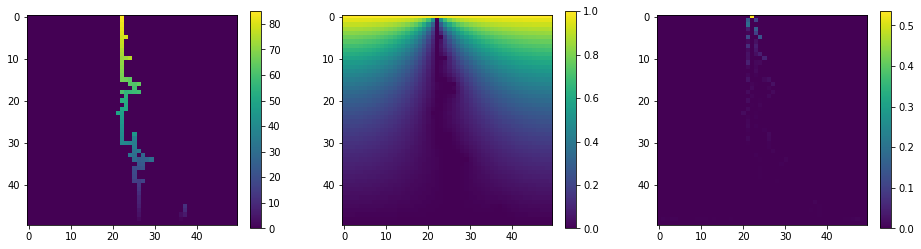

In [5]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.subplot(1,3,1)
plt.imshow(c.T) #create a plot of the lightning's path
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(s.T) #create a plot of the final potential
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(sprob.T) #create a plot of the relative probabilities of the next step
plt.colorbar()
plt.show()

## Additional questions you might investigate

1. What happens if there is a lightning rod or other conductor attached to the ground?
    * Remember that that E = 0 inside conductors, so there will be a constant potential around the edge
2. What happens if the stormcloud has a defined shape?
3. Does this simulation tell us anything about other cases, like cloud-to-ground lightning?
    * In real cases of cloud-to-ground lightning, lightning strikes consist of so-called "leaders" (charged ions that move down from a cloud) and "streamers" (oppositely charged ions that move upwards from the ground to meet the leader). Does this simulation allow us to understand anything about the conditions that create leaders and/or streamers?

*(Note that these are just meant to be suggestions—feel free to investigate any question you find interesting!)*